In [1]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi 
%matplotlib inline
RND_STATE = 55121

### 1. Loading data

In [2]:
data = pd.read_csv("data/tree_addhealth.csv")
data.columns = map(str.upper, data.columns)

#### 1.1 Removing rows with incomplete data

In [3]:
data_clean = data.dropna()

#### 1.2 Selecting clustering variables

In [4]:
cluster=data_clean[['ALCEVR1','MAREVER1','ALCPROBS1','DEVIANT1','VIOL1',
'DEP1','ESTEEM1','SCHCONN1','PARACTV', 'PARPRES','FAMCONCT']]

In [5]:
cluster.describe()

,ALCEVR1,MAREVER1,ALCPROBS1,DEVIANT1,VIOL1,DEP1,ESTEEM1,SCHCONN1,PARACTV,PARPRES,FAMCONCT
count,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000
mean,0.527432,0.241967,0.369180,2.645027,1.618579,8.537049,40.952131,28.360656,6.290710,13.398033,22.570557
std,0.499302,0.428321,0.894947,3.520554,2.593230,6.571052,5.381439,5.156385,3.360219,2.085837,2.614754
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,6.000000,0.000000,3.000000,6.300000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,38.000000,25.000000,4.000000,12.000000,21.700000
50%,1.000000,0.000000,0.000000,1.000000,0.000000,7.000000,40.000000,29.000000,6.000000,14.000000,23.700000
75%,1.000000,0.000000,0.000000,4.000000,2.000000,12.000000,45.000000,32.000000,9.000000,15.000000,24.300000
max,1.000000,1.000000,6.000000,27.000000,19.000000,48.000000,50.000000,38.000000,18.000000,15.000000,25.000000


### 2. Preprocessing data

#### 2.1 Scaling data

In [6]:
clustervar=cluster.copy()
clustervar['ALCEVR1']=preprocessing.scale(clustervar['ALCEVR1'].astype('float64'))
clustervar['ALCPROBS1']=preprocessing.scale(clustervar['ALCPROBS1'].astype('float64'))
clustervar['MAREVER1']=preprocessing.scale(clustervar['MAREVER1'].astype('float64'))
clustervar['DEP1']=preprocessing.scale(clustervar['DEP1'].astype('float64'))
clustervar['ESTEEM1']=preprocessing.scale(clustervar['ESTEEM1'].astype('float64'))
clustervar['VIOL1']=preprocessing.scale(clustervar['VIOL1'].astype('float64'))
clustervar['DEVIANT1']=preprocessing.scale(clustervar['DEVIANT1'].astype('float64'))
clustervar['FAMCONCT']=preprocessing.scale(clustervar['FAMCONCT'].astype('float64'))
clustervar['SCHCONN1']=preprocessing.scale(clustervar['SCHCONN1'].astype('float64'))
clustervar['PARACTV']=preprocessing.scale(clustervar['PARACTV'].astype('float64'))
clustervar['PARPRES']=preprocessing.scale(clustervar['PARPRES'].astype('float64'))

#### 2.2 Splitting into train test splits 

In [7]:
clus_train, clus_test = train_test_split(clustervar, test_size=0.3, random_state=RND_STATE)

### 3. Making k-means analysis for 1-9 clusters

In [8]:
clusters=range(1,10)
meandist=[]

In [9]:
for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(clus_train)
    clusassign=model.predict(clus_train)
    meandist.append(sum(np.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1)) 
    / clus_train.shape[0])

### 4. Plotting relation between number of clusters and average distance 

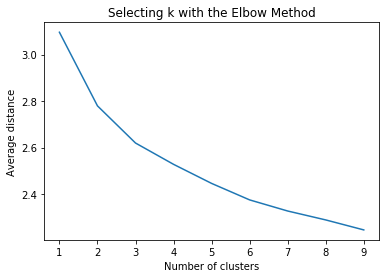

In [10]:
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')
plt.show()

### 5. Checking solution for 3 clusters model

In [11]:
model3=KMeans(n_clusters=3)
model3.fit(clus_train)
clusassign=model3.predict(clus_train)

#### 5.1 Plotting clusters

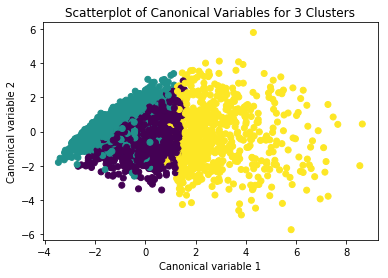

In [12]:
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(clus_train)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model3.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 3 Clusters')
plt.show()

#### 5.2 Merging cluster assignment with clustering variables to examine cluster variable means by cluster

In [13]:
clus_train.reset_index(level=0, inplace=True)
cluslist=list(clus_train['index'])
labels=list(model3.labels_)
newlist=dict(zip(cluslist, labels))

In [14]:
newclus=DataFrame.from_dict(newlist, orient='index')
newclus.columns = ['cluster']
newclus.describe()

,cluster
count,3202.000000
mean,0.849469
std,0.734614
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,2.000000


In [15]:
newclus.reset_index(level=0, inplace=True)
merged_train=pd.merge(clus_train, newclus, on='index')
merged_train.head(n=100)
merged_train.cluster.value_counts()

1    1402
0    1141
2     659
Name: cluster, dtype: int64

#### 5.3 Calculating clustering variable means by cluster

In [16]:
clustergrp = merged_train.groupby('cluster').mean()
print ("Clustering variable means by cluster")
print(clustergrp)

Clustering variable means by cluster
               index   ALCEVR1  MAREVER1  ALCPROBS1  DEVIANT1     VIOL1  \
cluster                                                                   
0        3289.223488  0.946562 -0.073844  -0.091315 -0.124480 -0.178736   
1        3282.679743 -1.056455 -0.473382  -0.412562 -0.454550 -0.265520   
2        3265.694992  0.685167  1.135741   0.940656  1.224217  0.856974   

             DEP1   ESTEEM1  SCHCONN1   PARACTV   PARPRES  FAMCONCT  
cluster                                                              
0       -0.156971  0.137081  0.127914  0.072073  0.083139  0.143204  
1       -0.293428  0.193017  0.316853  0.051040  0.143281  0.287596  
2        0.897279 -0.694999 -0.936129 -0.317314 -0.422218 -0.932709  


#### 5.4 Validating clusters in training data by examining cluster differences in GPA using ANOVA

In [17]:
gpa_data=data_clean['GPA1']
gpa_train, gpa_test = train_test_split(gpa_data, test_size=.3, random_state=123)
gpa_train1=pd.DataFrame(gpa_train)
gpa_train1.reset_index(level=0, inplace=True)
merged_train_all=pd.merge(gpa_train1, merged_train, on='index')
sub1 = merged_train_all[['GPA1', 'cluster']].dropna()

In [18]:
gpamod = smf.ols(formula='GPA1 ~ C(cluster)', data=sub1).fit()
print (gpamod.summary())

                            OLS Regression Results                            
Dep. Variable:                   GPA1   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     91.79
Date:                Sat, 11 Nov 2017   Prob (F-statistic):           4.74e-39
Time:                        18:54:50   Log-Likelihood:                -2560.4
No. Observations:                2257   AIC:                             5127.
Df Residuals:                    2254   BIC:                             5144.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.8105      0.026    1

In [19]:
print ('means for GPA by cluster')
m1= sub1.groupby('cluster').mean()
print (m1)


means for GPA by cluster
             GPA1
cluster          
0        2.810532
1        3.000589
2        2.421286


In [20]:
print ('standard deviations for GPA by cluster')
m2= sub1.groupby('cluster').std()
print (m2)

standard deviations for GPA by cluster
             GPA1
cluster          
0        0.740107
1        0.737632
2        0.806987


In [21]:
mc1 = multi.MultiComparison(sub1['GPA1'], sub1['cluster'])
res1 = mc1.tukeyhsd()
print(res1.summary())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1     0.1901   0.1066  0.2736  True 
  0      2    -0.3892  -0.4929 -0.2856  True 
  1      2    -0.5793  -0.6796  -0.479  True 
---------------------------------------------
